In [20]:
# Importing stuff
import pandas as pd
import numpy as np

from dataProcessing import processing
path = f'../Data'
dfs = processing(path)

In [21]:
# Importing TF and the TCN.

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tcn import TCN
from sklearn.preprocessing import StandardScaler

Temporal Convolutional Network

In [22]:
# The model consists of a temporal convolutional network, a ReLU, and a linear layer.

model = Sequential([
    
    # Temporal Convolutional Network layer
    TCN(input_shape = (num_features, 1), 
        kernel_size = 2, 
        use_skip_connections=True,
        use_batch_norm=True,
        use_layer_norm=True),
    
    # Dropout for regularization
    Dropout(0.2),

    # Fully connected layers
    Dense (4, 'relu'),
    Dense(1, activation='linear')
])


optimizer = Adam(learning_rate=0.01)
loss = MeanAbsolutePercentageError()

model.compile(optimizer = optimizer,loss = loss)
model.summary()

C:\Users\suhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_2 (TCN)                     │ (None, 64)             │        94,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,473 (369.04 KB)

 Trainable params: 92,937 (363.04 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [23]:
scaler = StandardScaler() # Converting into Z-score

for year in range(2021, 2024):

    # Shifting by 1, as we are using the data of the previous game to predict the 'PTS' of the next.
    dfs[f'Data\\{year}']['PtsNextGame'] = (dfs[f'Data\\{year}'])['PTS'].shift(-1) 

    X = dfs[f'Data\\{year}'].drop('PtsNextGame', axis = 1)
    y = dfs[f'Data\\{year}']['PtsNextGame']

    # Removing the NaN values formed at the last due to the shift

    X = X.iloc[:-1]
    y = y.iloc[:-1]

    X = X.to_numpy()
    y = y.to_numpy()

    X = X.reshape((X.shape[0], X.shape[1]))
    y = y.reshape(y.shape[0],1)

    X_normalized = scaler.fit_transform(X)

    model.fit(X_normalized,y,epochs = 5)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 82.8016
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 45.0835
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 33.0256
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 26.3130
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.4414
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 31.3601
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28.1863
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 24.6812
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 24.7479
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 23.3888
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 47.8514
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 39.7527
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 35.7609
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 32.9288
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 33.9456


Here, we are using the 2021 to 2023 seasons for training, and the 2024 season for testing. We essentially treat each season as a batch, feeding them to the model one at a time. Did not include the 2020 season as it is the only non MVP-level season of the sample set, and was messing with the predictions.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

dfs[f'Data\\2024']['PtsNextGame'] = (dfs[f'Data\\2024'])['PTS'].shift(-1) # Shifting by 1.

X_test = dfs['Data\\2024'].drop('PtsNextGame', axis = 1)
X_test = X_test.iloc[:-1] # Removing NaN value formed by shift.
X_test = scaler.fit_transform(X_test)

y_test = dfs['Data\\2024']['PtsNextGame']
y_test = y_test.iloc[:-1] # Removing NaN value formed by shift.

predictions = model.predict(X_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024AA136E340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


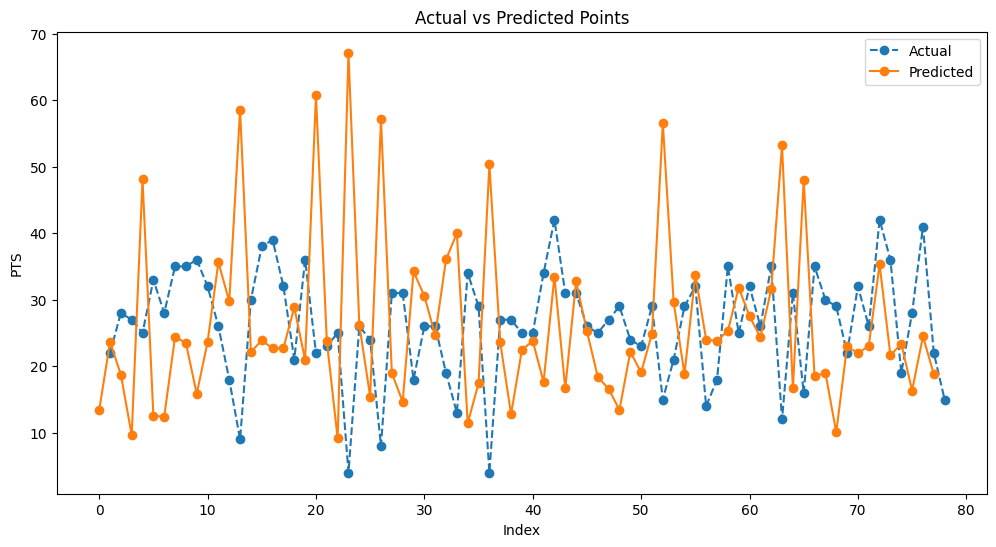

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linestyle='--', marker='o')
plt.plot(predictions, label='Predicted', linestyle='-', marker='o')
plt.xlabel('Index')
plt.ylabel('PTS')
plt.title('Actual vs Predicted Points')
plt.legend()
plt.show()

As we can see, the model matches the peaks pretty well, consdering the non-linearity and uneven distribution of this dataset. With some human intuition, it could be pretty useful.

In [26]:
# Euclidean Distance

model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 53.6839  


51.29365921020508

<Axes: >

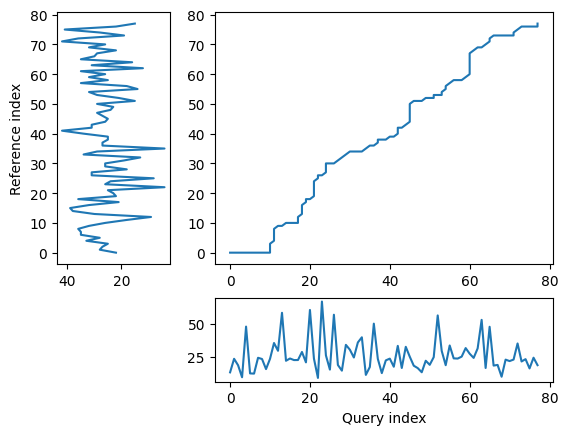

In [27]:
# Dynamic Time Warping algorithm similarity test 

from dtw import *

query = predictions
template = y_test.to_numpy()

alignment = dtw(query, template, keep_internals=True)
alignment.plot(type="threeway")

As we can see, the warping required appears relatively minimal, with the curve stationed along the diagonal.